In [1]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.linalg import sqrtm
from typing import Callable

## 1. Brownian motion

### 1.1 Simple Brownian motion trajectories

In [2]:
def create_path_BM(length: float, num_splits: int) -> np.ndarray:
    """
    length: float -- last moment of time to be simulated
    num_splits: int -- number of increments to create, 
    increment is \Delta W_t and it is sample from N(0, T/N)
    
    return trajectory of brownian motion
    """
    increments = np.random.normal(loc=0, 
                                  scale=(length/num_splits) ** 0.5, 
                                  size=num_splits)
    
    trajectory = np.zeros(num_splits+1)
    trajectory[1:] = np.cumsum(increments)
    return trajectory

In [3]:
def plot_trajectories(length: float, num_splits: int, num_traj: int, 
                      y_label: str = "$W_t$",
                      process_name: str = "Wiener process",
                      sim_func: Callable = create_path_BM, 
                      **sim_func_kwargs) -> None:
    """
    just a simple plotting function
    """
    
    plt.figure(figsize=(13, 7))
    for traj in range(num_traj):
        plt.plot(np.arange(0, length, length/(num_splits + 1)), 
                 sim_func(length, num_splits, **sim_func_kwargs))
    
    plt.xlabel("$t$")
    plt.ylabel(y_label)
    plt.title(f"Simulated trajectories of a {process_name}")
    plt.xlim(0, length)
    
    plt.show()

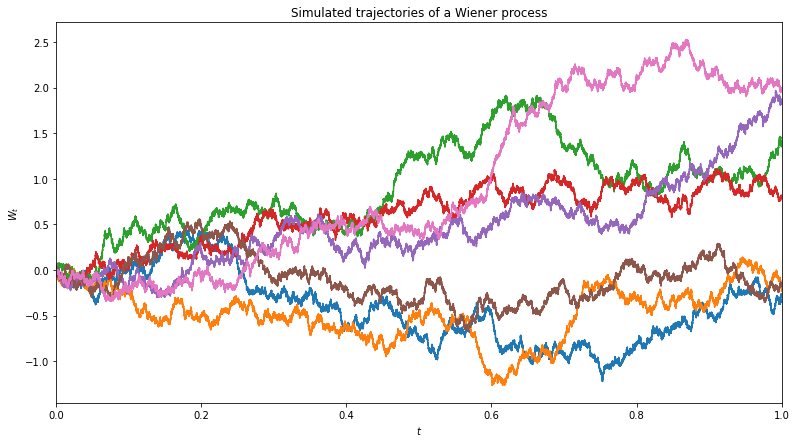

In [4]:
plot_trajectories(1, 100000, 7)

### 1.2 BM with drift

In [5]:
def create_path_BM_drift(length: float, num_splits: int,
                          slope: int = 0, sd: int = 1) -> np.ndarray:
    """
    Same as simple BM trajectories but with a slope and sd parameters
    
    return a trajectrory of Brownian motion with drift
    """
    basic_BM_traj = create_path_BM(length, num_splits)
    
    linear_part = slope * np.arange(0, length, length/(num_splits + 1))
    
    trajectory = linear_part + sd * basic_BM_traj
    return trajectory

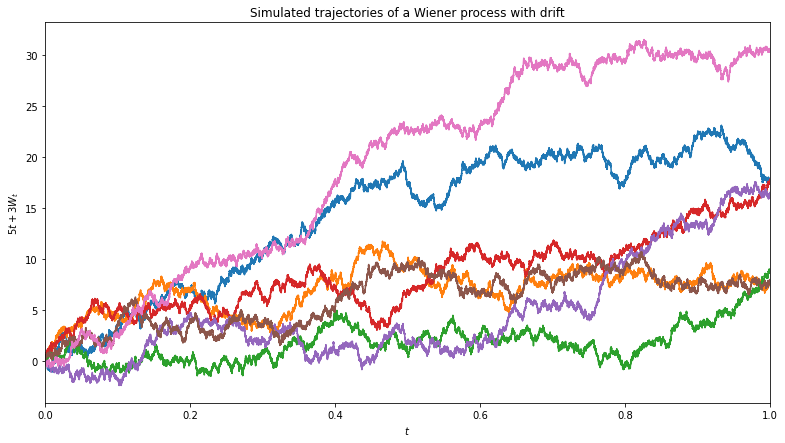

In [6]:
plot_trajectories(1, 100000, 7, f"${5}t + 3 W_t$", 
                  "Wiener process with drift",
                  create_path_BM_drift, slope=15, sd=8)

### 1.3 Brownian bridge

$$
B_t = W_t - \cfrac{t}{T} W_T
$$

In [7]:
def create_path_BB(length: float, num_splits: int) -> np.ndarray:
    """
    Same as create_path_BN
    
    return simulated brownian bridge
    """
    basic_BM_traj = create_path_BM(length, num_splits)
    
    linear_part = np.arange(0, length, length/(num_splits + 1))
    
    trajectory = basic_BM_traj - linear_part / length * basic_BM_traj[-1]
    return trajectory

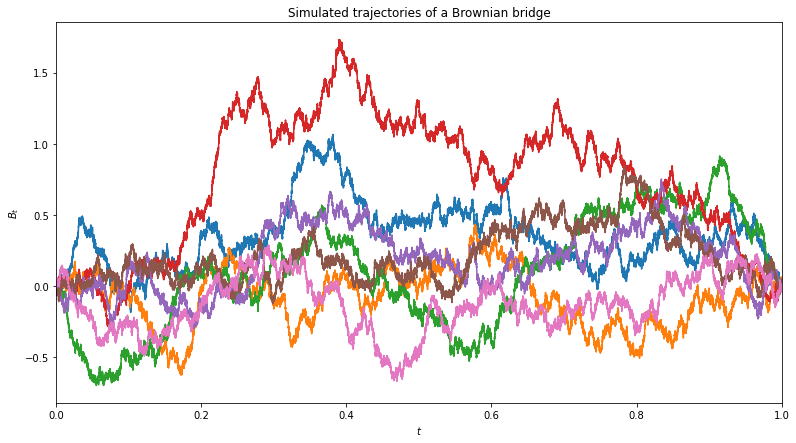

In [8]:
plot_trajectories(1, 100000, 7, 
                  "$B_t$", 
                  "Brownian bridge",
                  sim_func=create_path_BB)

### 1.4 Geometric Brownian Motion

$$
S_t = S_0 \exp((\mu - 0.5\sigma^2)t + \sigma W_t)
$$

In [9]:
def create_path_geometric_BM(length: float, num_splits: int,
                          mu: int = 0, sd: int = 1, s_0: int = 1) -> np.ndarray:
    """
    Same as simple BM trajectories but with a slope and sd parameters
    
    return a trajectrory of geometric Brownian motion 
    """
    basic_BM_traj = create_path_BM(length, num_splits)
    
    linear_part = (mu - sd/2) ** 2  * np.arange(0, length, length/(num_splits + 1))
    
    trajectory = s_0 * np.exp(linear_part + sd * basic_BM_traj)
    return trajectory

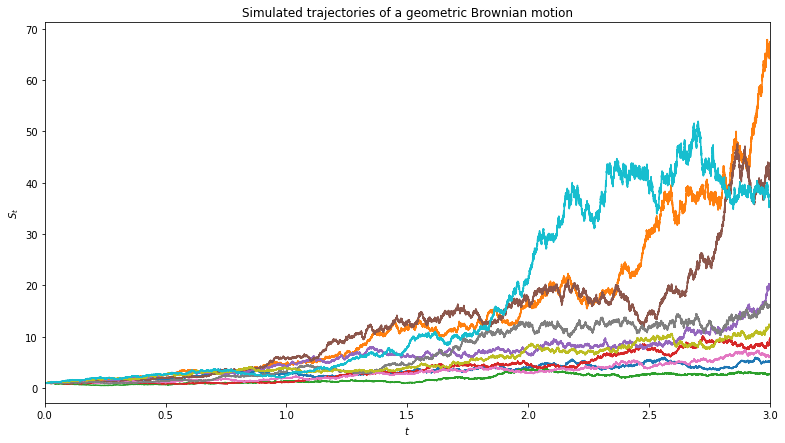

In [10]:
plot_trajectories(3, 100000, 10, 
                  "$S_t$", 
                  "geometric Brownian motion",
                  sim_func=create_path_geometric_BM, mu=1.2, sd=0.5)

## 2. SDE

### 2.1 Black-Scholes equation

$$
dX_t = \mu X_t dt + \sigma X_t dW_t
$$

Applying Ito's lemma to $d(ln X_t)$ we obtain that geometric Brownian motion is a solution to this equation

In [42]:
def Black_Scholes_SDE(length: float, num_splits: int,
                     mu: int = 0, sd: int = 1, x_0: int = 1,
                     order: int = 1) -> np.ndarray:
    
    
    delta = length / num_splits
    
    increments = np.random.normal(loc=0, 
                                  scale= delta ** 0.5, 
                                  size=num_splits)
    X_t = np.zeros(num_splits + 1)
    X_t[0] = x_0
    
    for i in range(1, num_splits):
        X_t[i] = X_t[i-1] + mu * X_t[i-1]* delta + sd * X_t[i-1] * increments[i]
        
        if order == 2:
            X_t[i] += 0.5 * (sd ** 2) * X_t[i-1] * (increments[i-1] ** 2 - delta)
    
    return X_t

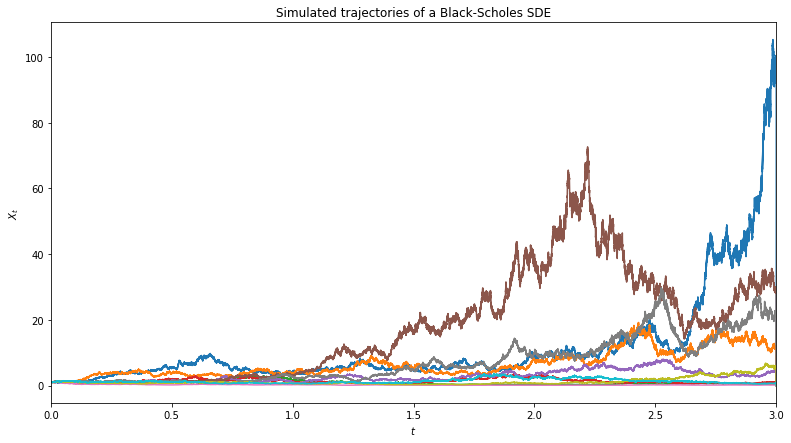

In [34]:
np.random.seed(13)

plot_trajectories(3, 100000, 10, 
                  "$X_t$", 
                  "Black-Scholes SDE",
                  sim_func=Black_Scholes_SDE, mu=1.2, sd=1)

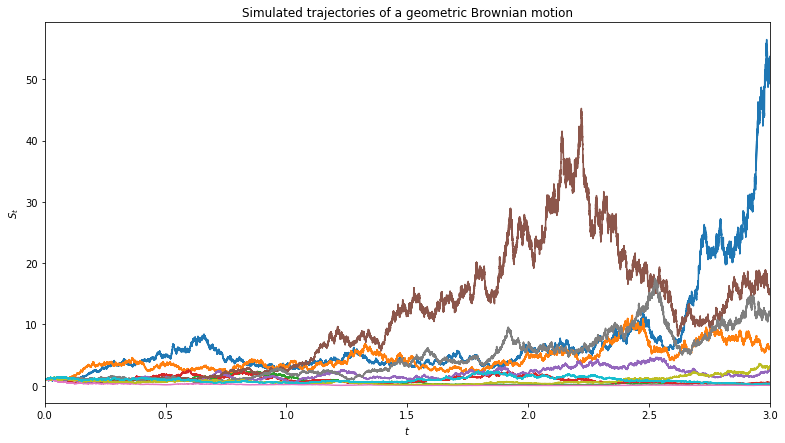

In [38]:
np.random.seed(13)
plot_trajectories(3, 100000, 10, 
                  "$S_t$", 
                  "geometric Brownian motion",
                  sim_func=create_path_geometric_BM, mu=1.2, sd=1)

As we can see both way of sampling yield equivalent results

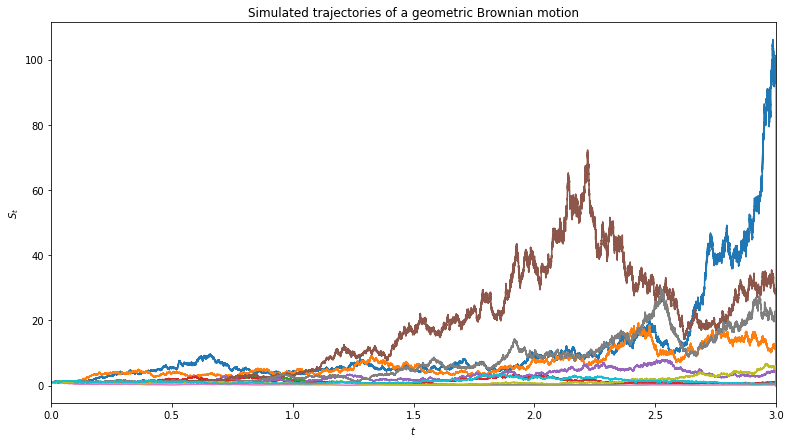

In [44]:
np.random.seed(13)
plot_trajectories(3, 100000, 10, 
                  "$S_t$", 
                  "geometric Brownian motion",
                  sim_func=Black_Scholes_SDE, 
                  mu=1.2, sd=1, order=2)

Graphically it is the same (and the errors were pretty small with such discretization). However, the order of convergence is higher here

In [55]:
def generate_mean_BS_SDE(length: float, num_splits: int,
                     mu: int = 0, sd: int = 1, x_0: int = 1,
                     order: int = 1, num_iter: int = 500):
    ### TODO: generalize 
    mean_trajectory = np.zeros(num_splits + 1)
    
    for i in range(num_iter):
        mean_trajectory += Black_Scholes_SDE(length, num_splits,
                                             mu, sd, x_0, order)
        
    mean_trajectory /= num_iter
    
    return mean_trajectory

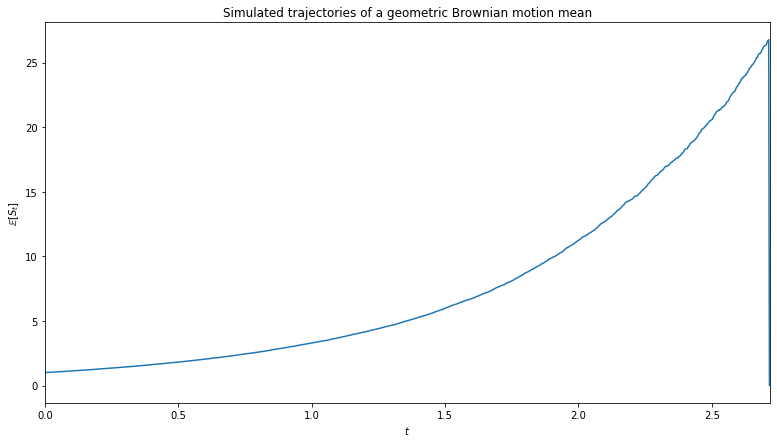

In [69]:
np.random.seed(13)

plot_trajectories(np.exp(1), 1000, 1, 
                  "$\mathbb{E}[S_t]$", 
                  "geometric Brownian motion mean",
                  generate_mean_BS_SDE, 
                  mu=1.2, sd=1, order=2, num_iter=10000)

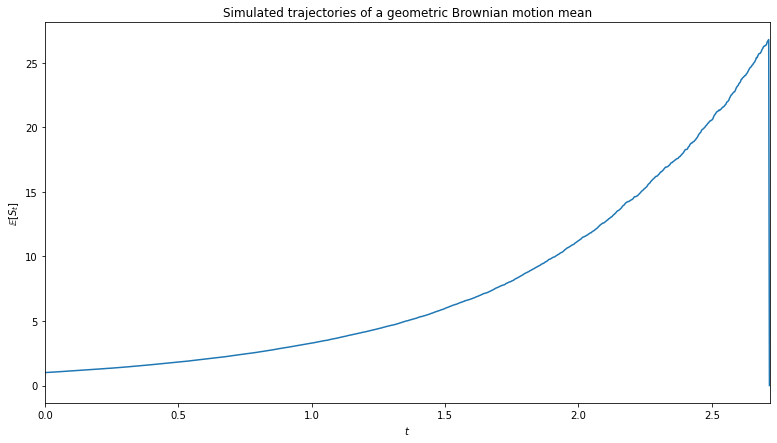

In [70]:
np.random.seed(13)

plot_trajectories(np.exp(1), 1000, 1, 
                  "$\mathbb{E}[S_t]$", 
                  "geometric Brownian motion mean",
                  generate_mean_BS_SDE, 

                  mu=1.2, sd=1, order=1, num_iter=10000)

In [78]:
np.random.seed(1)

first_order = generate_mean_BS_SDE(
    length=np.exp(1),
    num_splits=1000,
    mu=1.2,
    sd=1,
    order=1,
    num_iter=10000
)

second_order = generate_mean_BS_SDE(
    length=np.exp(1),
    num_splits=1000,
    mu=1.2,
    sd=1,
    order=1,
    num_iter=10000
)

real_mean = np.exp(1.2 * np.linspace(0, np.exp(1), 1001))

In [79]:
print(f"First order approximation MSE: {((first_order - real_mean) ** 2).mean()}")
print(f"Second order approximation MSE: {((second_order - real_mean) ** 2).mean()}")

First order approximation MSE: 0.8171186010931277
Second order approximation MSE: 0.7001986487422887


Second order way of sampling yields a smaller MSE!

### 2.2 Vasicek model

$$
dX_t = (a-bX_t) dt + c dW_t
$$

Here we apply Ito's lemma to $d(X_t e^{bt})$ and obtain formula
$$
X_t = e^{-bt}X_0 + \frac{a}{b}(1-e^{-bt}) + c \int_0^t e^{-b(s-t)} dW_s
$$

In [14]:
def Vasicek_SDE(length: float, num_splits: int,
                a: int = 1, b: int = 1, c: int = 1,
                x_0: int = 1) -> np.ndarray:
    
    
    delta = length / num_splits
    
    increments = np.random.normal(loc=0, 
                                  scale= delta ** 0.5, 
                                  size=num_splits)
    X_t = np.zeros(num_splits + 1)
    X_t[0] = x_0
    
    for i in range(1, num_splits):
        X_t[i] = X_t[i-1] + (a - b * X_t[i-1]) * delta + c * X_t[i-1] * increments[i]
    
    return X_t

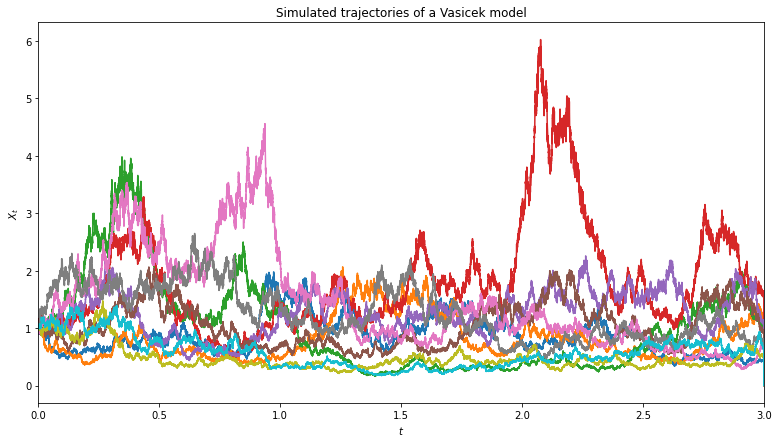

In [15]:
plot_trajectories(3, 100000, 10, 
                  "$X_t$", 
                  "Vasicek model",
                  sim_func=Vasicek_SDE)

### 2.3 Cox-Ingersoll-Ross model

A slightly different version of Vasicek model:
$$
dX_t = (a-bX_t) dt + c \sqrt{X_t} dW_t
$$

Ito's lemma to same function yields:
$$
X_t = e^{-bt}X_0 + \frac{a}{b}(1-e^{-bt}) + c \int_0^t e^{-b(s-t)}\sqrt{X_t} dW_s
$$

In [16]:
def CIR_SDE(length: float, num_splits: int,
                a: int = 1, b: int = 1, c: int = 1,
                x_0: int = 1) -> np.ndarray:
    
    
    delta = length / num_splits
    
    increments = np.random.normal(loc=0, 
                                  scale= delta ** 0.5, 
                                  size=num_splits)
    X_t = np.zeros(num_splits + 1)
    X_t[0] = x_0
    
    for i in range(1, num_splits):
        X_t[i] = X_t[i-1] + (a - b * X_t[i-1]) * delta + c * (X_t[i-1] ** 0.5) * increments[i]
    
    return X_t

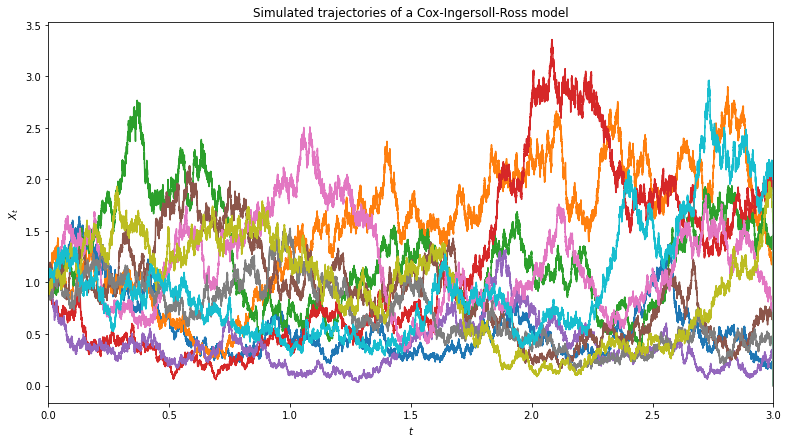

In [17]:
plot_trajectories(3, 100000, 10, 
                  "$X_t$", 
                  "Cox-Ingersoll-Ross model",
                  sim_func=CIR_SDE)

Notice that both Vasicek and CIR are mean-reverting

### 2.4 Heston’s Stochastic Volatility Model

\begin{eqnarray}
dX_t = rX_t dt + \sqrt{V_t} X_t d W_t^{(1)} \\
dV_t = \kappa (\theta - V_t)dt + \sigma \sqrt{V_t} d W_t^{(2)} \\
d W_t^{(1)}d W_t^{(2)} = \rho dt
\end{eqnarray}

In [24]:
def Hestons_SDE(length: float, num_splits: int,
                r: int = 0.5, kappa: int = 1.2, theta: int = 0.3, 
                sigma: int = 0.3, rho: int = -0.5,
                x_0: int = 100, v_0: int = 0.5) -> np.ndarray:
    
    delta = length / num_splits
    
    W1_traj = create_path_BM(length, num_splits)
    W2_traj = create_path_BM(length, num_splits)
    
    correlated_traj = np.c_[W1_traj, W2_traj] @ sqrtm(np.array([[1, rho], [rho, 1]]))
    W1_traj, W2_traj = correlated_traj[:, 0], correlated_traj[:, 1]
    
    X_t = np.zeros(num_splits + 1)
    V_t = np.zeros(num_splits + 1)
    
    X_t[0] = x_0
    V_t[0] = v_0
    
    for i in range(1, num_splits):
        X_t[i] = X_t[i-1] + r * X_t[i-1] * delta + np.sqrt(V_t[i-1]) * X_t[i-1] * (W1_traj[i] - W1_traj[i-1])
        V_t[i] = V_t[i-1] + kappa * (theta - V_t[i-1]) * delta + sigma * V_t[i-1] ** 0.5 * (W2_traj[i] - W2_traj[i-1])
    return X_t

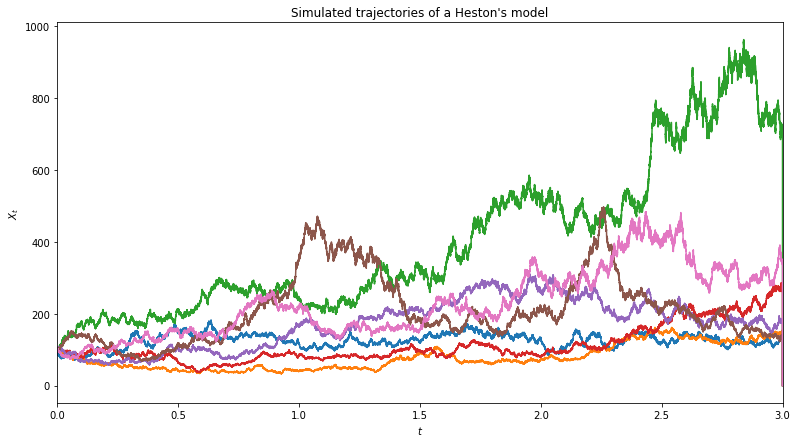

In [27]:
plot_trajectories(3, 100000, 7, 
                  "$X_t$", 
                  "Heston's model",
                  sim_func=Hestons_SDE)

## 3. Levy processes